In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm_notebook
import pickle
import os
import logging
import time
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset.mask_functions import rle2mask, mask2rle
from dataset.dataset import prepare_trainset
from utils.utils import save_checkpoint, load_checkpoint, set_logger
from utils.gpu_utils import set_n_get_device

#from model.deeplab_model_kaggler.deeplab import DeepLab
#from model.model_unet_classify_zero import UNetResNet34 as ZeroMaskClassifier
#from model.CSAILVision.models.models import SegmentationModule
#from model.model_unet import UNetResNet34
#from model.model_plain_unet import UNetResNet34
#from model.model_resnet_fpn import FPNResNet34
from model.deeplab_model_kaggler.lr_scheduler import LR_Scheduler

import segmentation_models_pytorch as smp

%matplotlib inline

In [2]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'b3'
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("2", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = None #None#[0, 1]#use 2 gpus

SEED = 1234 #5678#4567#3456#2345#1234
debug = True# if True, load 100 samples
IMG_SIZE = (512, 768)
BATCH_SIZE = 4
NUM_WORKERS = 24
torch.cuda.manual_seed_all(SEED)

====MODEL ACHITECTURE: b3====


## the dataset

In [6]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug)

Count images in train/test folder:  5546 3698
Count of trainset (for training):  942
Count of validset (for training):  166


In [7]:
for i, (images, masks) in enumerate(train_dl):
    images = images.to(device=device, dtype=torch.float)
    masks = masks.to(device=device, dtype=torch.float)
    #labels = (torch.sum(masks.reshape(masks.size()[0], -1), dim=1, keepdim=True)==0).to(device=device, dtype=torch.float) #1 for non-zero-mask
    if i==0:
        break

In [8]:
images.size(), masks.size()#, labels.size()

(torch.Size([4, 1, 512, 768]), torch.Size([4, 4, 512, 768]))

## the model

In [4]:
# net = DeepLab(num_classes=4,
#               backbone=MODEL,#resnet34, resnet101
#               output_stride=16,#default 16, 8
#               sync_bn=None,
#               freeze_bn=False,
#               debug=True
#              ).cuda(device=device)

#net = SegmentationModule(net_enc='resnet50', net_dec='upernet').cuda(device=device)
#net = SegmentationModule(net_enc='hrnetv2', net_dec='c1').cuda(device=device)

#net = UNetResNet34(debug=True).cuda(device=device)
#net = FPNResNet34(debug=debug).cuda(device=device)

#net = smp.PSPNet(encoder_name='resnet34', classes=4, activation=None)
net = smp.Unet(encoder_name='efficientnet-b3', 
         encoder_weights='imagenet', 
         classes=4,
         activation=None,
         center=True)

#checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed3456/best.pth.tar'
#net, _ = load_checkpoint(checkpoint_path, net)

if multi_gpu is not None:
    net = nn.DataParallel(net, device_ids=multi_gpu)

Downloading: "http://storage.googleapis.com/public-models/efficientnet/efficientnet-b3-5fb5a3c3.pth" to /home/endi.niu/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 49388949/49388949 [00:02<00:00, 19715146.27it/s]


In [5]:
for param in net.named_parameters():
    print(param[0])

encoder._conv_stem.weight
encoder._bn0.weight
encoder._bn0.bias
encoder._blocks.0._depthwise_conv.weight
encoder._blocks.0._bn1.weight
encoder._blocks.0._bn1.bias
encoder._blocks.0._se_reduce.weight
encoder._blocks.0._se_reduce.bias
encoder._blocks.0._se_expand.weight
encoder._blocks.0._se_expand.bias
encoder._blocks.0._project_conv.weight
encoder._blocks.0._bn2.weight
encoder._blocks.0._bn2.bias
encoder._blocks.1._depthwise_conv.weight
encoder._blocks.1._bn1.weight
encoder._blocks.1._bn1.bias
encoder._blocks.1._se_reduce.weight
encoder._blocks.1._se_reduce.bias
encoder._blocks.1._se_expand.weight
encoder._blocks.1._se_expand.bias
encoder._blocks.1._project_conv.weight
encoder._blocks.1._bn2.weight
encoder._blocks.1._bn2.bias
encoder._blocks.2._expand_conv.weight
encoder._blocks.2._bn0.weight
encoder._blocks.2._bn0.bias
encoder._blocks.2._depthwise_conv.weight
encoder._blocks.2._bn1.weight
encoder._blocks.2._bn1.bias
encoder._blocks.2._se_reduce.weight
encoder._blocks.2._se_reduce.bias

In [15]:
LearningRate = 0.01
NUM_EPOCHS = 40
enc_params = [p[1] for p in net.named_parameters() if ('resnet' in p[0] or 'encoder' in p[0])]
other_params = [p[1] for p in net.named_parameters() if ('resnet' not in p[0] and 'encoder' not in p[0])]
train_params = [{'params': enc_params, 'lr': LearningRate},
                {'params': other_params, 'lr': LearningRate * 10}]

optimizer = torch.optim.SGD(train_params, momentum=0.9, weight_decay=0.0001, lr=LearningRate)
#scheduler = LR_Scheduler('poly', LearningRate, NUM_EPOCHS, len(train_dl))#lr_scheduler=['poly', 'step', 'cos']
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                      factor=0.5, patience=4,#4 resnet34 
                                                      verbose=False, threshold=0.0001, 
                                                      threshold_mode='rel', cooldown=0, 
                                                      min_lr=0, eps=1e-08)

val_metric = 0
for i_epoch in range(NUM_EPOCHS):
    #for i, (image, masks) in enumerate(train_dl):
    if np.random.randn(1)>0:
        val_metric -= 1
    print(val_metric)
    scheduler.step(val_metric)
    

-1
-2
-2
-2
-3
-4
-4
-4
-5
-5
-6
-6
-7
-7
-7
-8
-9
-9
-9
-10
-10
-10
-10
-11
-12
-13
-14
-15
-15
-15
-15
-15
-15
-15
-16
-17
-17
-17
-18
-18


In [9]:
logit = net(images)

RuntimeError: Given groups=1, weight of size 64 3 7 7, expected input[4, 1, 512, 768] to have 3 channels, but got 1 channels instead

In [13]:
logit.size(), masks.size()

(torch.Size([4, 4, 512, 768]), torch.Size([4, 4, 512, 768]))

In [14]:
_loss = net.criterion(logit, masks, nonempty_only=False)
_loss

tensor(0.7799, device='cuda:0', grad_fn=<AddBackward0>)

In [15]:
_metric = net.metric(logit, masks, nonempty_only=False)
_metric

tensor(0.0789, device='cuda:0')

## predict the validset, and analyse

In [ ]:
#move checkpoint from gamma machine to here
cd checkpoint
scp -r endi.niu@10.171.36.214:/home/endi.niu/SIIM/checkpoint/deeplabv3plus_resnet_1280_v2_seed2345/ deeplabv3plus_resnet_1280_v2_seed2345
cd logging
scp -r endi.niu@10.171.36.214:/home/endi.niu/SIIM/logging/deeplabv3plus_resnet_1280_v2_seed2345.log deeplabv3plus_resnet_1280_v2_seed2345.log


In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook
import pickle
import os
import logging
import time
import gc
from IPython.core.debugger import set_trace
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.utils import save_checkpoint, load_checkpoint, set_logger
from utils.gpu_utils import set_n_get_device

from dataset.dataset import prepare_trainset


use_model = 0
if use_model==0:
    from model.deeplab_model_kaggler.deeplab import DeepLab, predict_proba
elif use_model==1:
    from model.EfficientUnet.efficient_unet import Efficient_Unet, predict_proba
elif use_model==2:
    from model.CSAILVision.models.models import SegmentationModule, predict_proba
elif use_model==3:
    from model.model_unet import UNetResNet34, predict_proba
elif use_model==4:#FPNResNet34
    from model.model_resnet_fpn import FPNResNet34, predict_proba
elif use_model==5:
    from model.model_plain_unet import UNetResNet34, predict_proba
elif use_model==6:
    from model.model_pspnet import PSPNet, predict_proba

#from model.model_unet_classify_zero import UNetResNet34 as NonzeroClf
#from model.model_unet_classify_zero import predict_proba as predict_proba_nonzero

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(x):
    return np.log(x / (1-x))

%matplotlib inline

In [2]:
######### Config the training process #########

if use_model==0:
    MODEL = 'resnet'
elif use_model==1:
    MODEL = 'b5'
elif use_model==2:
    MODEL = ''
elif use_model==3:
    MODEL = 'UNetResNet34'
elif use_model==4:
    MODEL = 'resnet34'
elif use_model==5:
    MODEL = 'resnet34'
elif use_model==6:
    MODEL = 'resnet34'
else:
    MODEL = ''
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("0,1,2,3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = [0,1,2,3] #None#[0, 1]#use 2 gpus

SEED = 2110
debug = False# if True, load 100 samples
if use_model==0:
    IMG_SIZE = (512, 768) #(1024, 1536) #(768, 1152) #(512, 768)
    output_shape = None
elif use_model==2:
    IMG_SIZE = (512, 768)
    output_shape = None
elif use_model==4:
    IMG_SIZE = (512, 768)#(1024, 1536)
    output_shape = None#(512, 768)
elif use_model==5:
    IMG_SIZE = (512, 768)
    output_shape = None
elif use_model==6:
    IMG_SIZE = (512, 768)
    output_shape = None
BATCH_SIZE = 32#64
NUM_WORKERS = 24
torch.cuda.manual_seed_all(SEED)

====MODEL ACHITECTURE: resnet====


In [3]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug, 
                                    nonempty_only=False, crop=False, output_shape=output_shape)

Count images in train/test folder:  5546 3698
Count of trainset (for training):  4714
Count of validset (for training):  832


In [4]:
# y should be makeup
y_valid = []
for i, (image, masks) in enumerate(val_dl):
    #if i==10:
    #    break
    #truth = masks.to(device=device, dtype=torch.float)
    y_valid.append(masks.numpy())
y_valid = np.concatenate(y_valid, axis=0)
y_valid.shape

(832, 4, 512, 768)

In [5]:
if use_model==0:
    net = DeepLab(num_classes=4,
                  backbone=MODEL,#resnet34, resnet101
                  output_stride=16,#default 16, 8
                  sync_bn=None,
                  freeze_bn=False,
                  debug=False, 
                  clf_path=True
                 ).cuda(device=device)
elif use_model==1:
    net = Efficient_Unet(num_class=4, drop_connect_rate=0.2).cuda(device=device)
elif use_model==2:
    #net = SegmentationModule(net_enc='resnet50', net_dec='upernet').cuda(device=device)
    net = SegmentationModule(net_enc='hrnetv2', net_dec='c1').cuda(device=device)
elif use_model==3:
    net = UNetResNet34(debug=False).cuda(device=device)
elif use_model==4:
    net = FPNResNet34(debug=False).cuda(device=device)
elif use_model==5:
    net = UNetResNet34(debug=False).cuda(device=device)

#checkpoint_path = '../checkpoint/deeplabv3plus_resnet_512x768_v6_seed2001/best.pth.tar'
#checkpoint_path = '../checkpoint/deeplabv3plus_resnet_400x600_v7_seed2013/best.pth.tar'
#checkpoint_path = '../checkpoint/deeplabv3plus_resnet_768x1152_v7_seed2016/best.pth.tar'
#checkpoint_path = '../checkpoint/deeplabv3plus_resnet_512x768_v12_seed2041/best.pth.tar'
#checkpoint_path = '../checkpoint/UNetResNet34_512x768_v3_seed2034/best.pth.tar'
#checkpoint_path = '../checkpoint/fpn_resnet34_512x768_v1_seed2034/best.pth.tar'
#checkpoint_path = '../checkpoint/fpn_resnet34_768x1152_v1_seed2034/best.pth.tar'

#checkpoint_path = '../checkpoint/fpn_resnet34_1024x1536_v1_seed2042/best.pth.tar'
#checkpoint_path = '../checkpoint/deeplabv3plus_resnet_512x768_v13_seed2046/best.pth.tar'
#checkpoint_path = '../checkpoint/unet_resnet34_512x768_v1_seed2061/best.pth.tar'
checkpoint_path = '../checkpoint/CSAILVision_hrnetv2_c1_512x768_v3_seed2110/best.pth.tar'

net, _ = load_checkpoint(checkpoint_path, net)

if multi_gpu is not None:
    net = nn.DataParallel(net, device_ids=multi_gpu)

In [22]:
# ## tta: flip lr + ud
# def predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True):
#     if tta:
#         print("use TTA")
#     else:
#         print("not use TTA")
#     y_pred = None
#     if multi_gpu:
#         net.module.set_mode('test')
#     else:
#         net.set_mode('test')
#     with torch.no_grad():
#         if mode=='valid':
#             for i, (image, masks) in enumerate(test_dl):
#                 input_data = image.to(device=device, dtype=torch.float)
#                 logit = net(input_data).cpu().numpy()
#                 if tta:#horizontal/vertical flip
#                     input_data_flip_lr = torch.flip(image, [3]).to(device=device, dtype=torch.float)
#                     logit_flip_lr = net(input_data_flip_lr).cpu().numpy()[:,:,:,::-1]
#                     input_data_flip_ud = torch.flip(image, [2]).to(device=device, dtype=torch.float)
#                     logit_flip_ud = net(input_data_flip_ud).cpu().numpy()[:,:,::-1,:]                    
#                     logit = (logit + logit_flip_lr + logit_flip_ud) / 3
#                 if y_pred is None:
#                     y_pred = logit
#                 else:
#                     y_pred = np.concatenate([y_pred, logit], axis=0)
#         elif mode=='test':
#             for i, image in enumerate(test_dl):
#                 input_data = image.to(device=device, dtype=torch.float)
#                 logit = net(input_data).cpu().numpy()
#                 if tta:#horizontal/vertical flip
#                     input_data_flip_lr = torch.flip(image, [3]).to(device=device, dtype=torch.float)
#                     logit_flip_lr = net(input_data_flip_lr).cpu().numpy()[:,:,:,::-1]
#                     input_data_flip_ud = torch.flip(image, [2]).to(device=device, dtype=torch.float)
#                     logit_flip_ud = net(input_data_flip_ud).cpu().numpy()[:,:,::-1,:]                    
#                     logit = (logit + logit_flip_lr + logit_flip_ud) / 3
#                 if y_pred is None:
#                     y_pred = logit
#                 else:
#                     y_pred = np.concatenate([y_pred, logit], axis=0)
#     h,w = y_pred.shape[2], y_pred.shape[3]
#     return y_pred.reshape(-1, 4, h, w)#Nx4x256x1600

In [6]:
%%time
preds_valid, preds_valid_clf = predict_proba(net, val_dl, device, multi_gpu=multi_gpu, mode='valid', tta=True)

use TTA
CPU times: user 4min 54s, sys: 41.3 s, total: 5min 35s
Wall time: 56 s


In [7]:
y_valid.shape, preds_valid.shape, preds_valid_clf.shape

((832, 4, 512, 768), (832, 4, 512, 768), (832, 4))

In [9]:
# ## NonzeroClf predict 4-ch-empty and delete mask
# net_clf = NonzeroClf(debug=False).cuda(device=device)
# checkpoint_path = '../checkpoint/nonzero_classifier_UNetResNet34_256x1600_v2_seed1234/best.pth.tar'
# net_clf, _ = load_checkpoint(checkpoint_path, net_clf)

# if multi_gpu is not None:
#     net_clf = nn.DataParallel(net_clf, device_ids=multi_gpu)

# preds_valid_clf = predict_proba_nonzero(net_clf, val_dl, device, multi_gpu=multi_gpu, mode='valid', tta=True)
# preds_valid_clf.shape

In [8]:
def dice_overall(pred, truth, eps=1e-8):
#     if nonempty_only:
#         n, c = truth_mask.shape[0], truth_mask.shape[1]
#         pred_mask = pred_mask.reshape(n*c, -1)
#         truth_mask = truth_mask.reshape(n*c, -1)
#         indexing = truth_mask.sum(axis=1)>0
#         pred_mask = pred_mask[indexing]
#         truth_mask = truth_mask[indexing]
#         eps = 0.0
    ## the correct LB metric: if both GT and pred empty mask image, then dice score=1
    is_empty = (truth.sum(axis=1)==0) * (pred.sum(axis=1)==0)
    truth_pos = truth[(1-is_empty).astype(bool)]
    pred_pos = pred[(1-is_empty).astype(bool)]
    intersect_pos = (pred_pos * truth_pos).sum(axis=1).astype(np.float)
    union_pos = (pred_pos + truth_pos).sum(axis=1).astype(np.float)
    dice_pos = ((2.0*intersect_pos + eps) / (union_pos+eps)).sum()
    return (dice_pos + is_empty.sum()) / truth.shape[0]
#     intersect = (pred * truth).sum(axis=1).astype(np.float)
#     union = (pred + truth).sum(axis=1).astype(np.float)
#     return ((2.0*intersect + eps) / (union+eps)).mean()

# h, w = 256, 1600
# print('For reference')
# print('EMPTY_THRESHOLD: ', 400*(h/256)*(w/1600))
# print('MASK_THRESHOLD: ', 0.5)

In [12]:
# search for best thresholds
def calculate_dice(logit, truth, EMPTY_THRESHOLD=[200,1500,1500,2000], MASK_THRESHOLD=0.22, CLF_THRESHOLD=0.7, logit_clf=None):
    n, c = truth.shape[0], truth.shape[1]
#     h, w = truth.shape[2], truth.shape[3]
#     logit = logit.reshape(n*c, h, w)
#     truth = truth.reshape(n*c, h, w)
#     logit = np.array([cv2.resize(ch, (525, 350)) for ch in logit])
#     truth = np.array([cv2.resize(ch, (525, 350)) for ch in truth])
    MASK_THRESHOLD = np.concatenate([MASK_THRESHOLD]*n).reshape(-1, 1)
    
    logit = sigmoid(logit).reshape(n*c, -1)
    truth = truth.reshape(n*c, -1)
    pred = (logit>MASK_THRESHOLD).astype(np.int)
    if logit_clf is not None:
        logit_clf = sigmoid(logit_clf).reshape(n*c, -1)
    
    EMPTY_THRESHOLD_4ch = np.concatenate([EMPTY_THRESHOLD]*n)#.reshape(-1, 1)
    pred_clf = (pred.sum(axis=1)<EMPTY_THRESHOLD_4ch).astype(np.int)
    pred[pred_clf==1, ] = 0#.reshape(-1,)
    if logit_clf is not None:
        pred[logit_clf.squeeze()<CLF_THRESHOLD, ] = 0
    #pos_ratio
    print('truth pos_ratio: ', (truth.sum(axis=1)>0).mean())
    print('pred pos_ratio: ', (pred.sum(axis=1)>0).mean())
    print('truth mean pixel: ', truth.mean())
    print('pred mean pixel: ', pred.mean())
    return dice_overall(pred, truth)#nonempty_only

import copy


#nonempty_only = False #for model trained only on nonempty-mask-channels

#[[i]*4 for i in np.arange(1, 10000, 2000)] #[[i]*4 for i in np.arange(10000, 45000, 5000)]
EMPTY_THRESHOLD_candidate = [[1]*4, [1000]*4, [5000]*4]
CLF_THRESHOLD_candidate = [0.5, 0.6, 0.7, 0.8]
MASK_THRESHOLD_candidate = [[.3]*4, [.35]*4, [.4]*4, [.45]*4]

best_threshold_EMPTY = [1, 1, 1, 1] #[25000, 25000, 25000, 25000]
best_threshold_CLF = 0.6 #0.7
best_threshold_MASK = [0.3]*4 #0.3
best_score = 0

opt_mask = 0
opt_logit_clf = 0
opt_clf = 0

if opt_mask + opt_logit_clf + opt_clf == 0:
    print('best_threshold_EMPTY: ', best_threshold_EMPTY)
    print('best_threshold_CLF: ', best_threshold_CLF)
    print('best_threshold_MASK: ', best_threshold_MASK)
    best_score = calculate_dice(preds_valid, y_valid, best_threshold_EMPTY, best_threshold_MASK, 
                         best_threshold_CLF, preds_valid_clf)
    print(best_score)

##==========================##
## pixel 0-1 threshold ##
if opt_mask:
    for MASK_THRESHOLD in MASK_THRESHOLD_candidate:
        EMPTY_THRESHOLD, CLF_THRESHOLD = best_threshold_EMPTY, best_threshold_CLF
        dice_score = calculate_dice(preds_valid, y_valid, EMPTY_THRESHOLD, MASK_THRESHOLD, CLF_THRESHOLD, preds_valid_clf)
        print('MASK_THRESHOLD: %s, dice_score: %f'%(str(MASK_THRESHOLD), dice_score))
        if dice_score>best_score:
            best_threshold_MASK = MASK_THRESHOLD
            best_score = dice_score

##==========================##
## logit clf threshold
if opt_logit_clf:
    for CLF_THRESHOLD in CLF_THRESHOLD_candidate:
        EMPTY_THRESHOLD, MASK_THRESHOLD = best_threshold_EMPTY, best_threshold_MASK
        dice_score = calculate_dice(preds_valid, y_valid, EMPTY_THRESHOLD, MASK_THRESHOLD, CLF_THRESHOLD, preds_valid_clf)
        print('CLF_THRESHOLD: %s, dice_score: %f'%(str(CLF_THRESHOLD), dice_score))
        if dice_score>best_score:
            best_threshold_CLF = CLF_THRESHOLD
            best_score = dice_score

##==========================##
## remove pixel when sum<threshold ##
if opt_clf:
    for EMPTY_THRESHOLD in tqdm_notebook(EMPTY_THRESHOLD_candidate):
        MASK_THRESHOLD, CLF_THRESHOLD = best_threshold_MASK, best_threshold_CLF
        dice_score = calculate_dice(preds_valid, y_valid, EMPTY_THRESHOLD, MASK_THRESHOLD, CLF_THRESHOLD, preds_valid_clf)
        print('EMPTY_THRESHOLD: %s, dice_score: %f'%(str(EMPTY_THRESHOLD), dice_score))
        if dice_score>best_score:
            best_threshold_EMPTY = copy.deepcopy(EMPTY_THRESHOLD)
            best_score = dice_score

best_threshold_EMPTY:  [1, 1, 1, 1]
best_threshold_CLF:  0.6
best_threshold_MASK:  [0.3, 0.3, 0.3, 0.3]
truth pos_ratio:  0.5336538461538461
pred pos_ratio:  0.4131610576923077
truth mean pixel:  0.15079583
pred mean pixel:  0.1442530888777513
0.6349317709140043


In [10]:
best_threshold_EMPTY, best_threshold_MASK, best_threshold_CLF, best_score

#[34000, 36000, 34000, 20000], [0.7, 0.7, 0.7, 0.7], 0.656845819992622

([1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3], 0.7, 0.6328574237403071)

In [13]:
# ## experiment?
# best_threshold_EMPTY, best_threshold_MASK, best_score = ([50000, 50000, 50000, 50000], 
#                                                          [0.65, 0.65, 0.65, 0.65], None)
# best_threshold_EMPTY, best_threshold_MASK, best_score

In [3]:
def predict_mask(logit, EMPTY_THRESHOLD, MASK_THRESHOLD, CLF_THRESHOLD=0.7, logit_clf=None, use_sigmoid=True):
    """Transform each prediction into mask.
    input shape: (256, 256)
    """
    #pred mask 0-1 pixel-wise
    #n = logit.shape[0]
    #IMG_SIZE = logit.shape[-1] #256
    #EMPTY_THRESHOLD = 100.0*(IMG_SIZE/128.0)**2 #count of predicted mask pixles<threshold, predict as empty mask image
    #MASK_THRESHOLD = 0.22
    #logit = torch.sigmoid(torch.from_numpy(logit)).view(n, -1)
    #pred = (logit>MASK_THRESHOLD).long()
    #pred[pred.sum(dim=1) < EMPTY_THRESHOLD, ] = 0 #bug here, found it, the bug is input shape is (256, 256) not (16,256,256)
    
    #logit = cv2.resize(logit, (525, 350))
    if use_sigmoid:
        logit = sigmoid(logit)#.reshape(n, -1)
        if logit_clf is not None:
            logit_clf = sigmoid(logit_clf)
    pred = (logit>MASK_THRESHOLD).astype(np.int)
    if pred.sum() < EMPTY_THRESHOLD:
        return np.zeros(pred.shape).astype(np.int)
    if logit_clf is not None and logit_clf<CLF_THRESHOLD:
        return np.zeros(pred.shape).astype(np.int)
    else:
        return pred

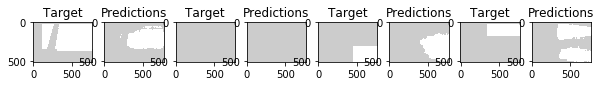

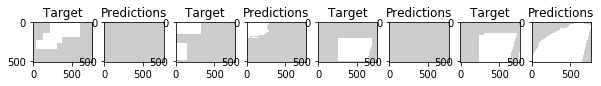

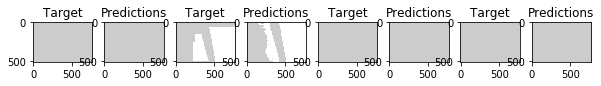

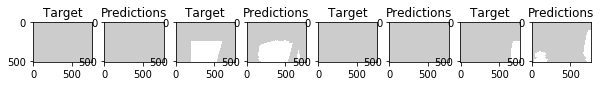

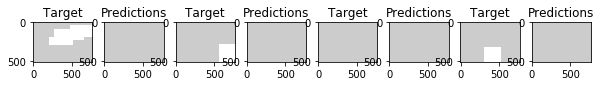

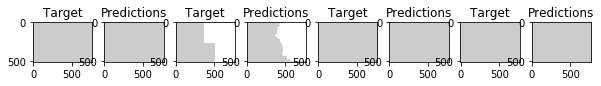

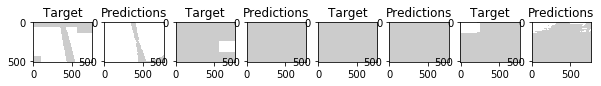

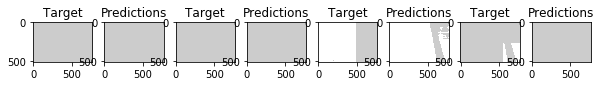

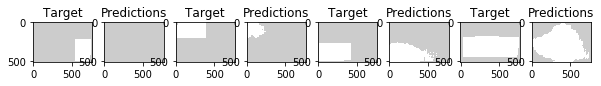

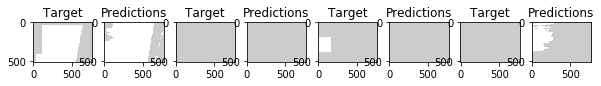

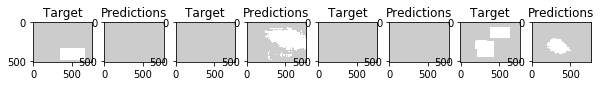

In [19]:
## visualize predicted masks
start = 3
rows = 10

#cmaps = {0: "Reds", 1: "Blues", 2: "Greens", 3: "Oranges"}
titles = {0: "Class=1", 1: "Class=2", 2: "Class=3", 3: "Class=4"}

cnt = 0
for idx, (img, mask) in enumerate(val_dl):
    if idx<start:
        continue
    mask = mask.numpy()
    img = img.numpy()
    for j in range(BATCH_SIZE):#BATCH_SIZE=8
        cnt+=1
        fig, axes = plt.subplots(ncols=8, figsize=(10, 8))
        for ch in range(4):
            if preds_valid_clf is not None:
                _preds_valid_clf = preds_valid_clf[idx*BATCH_SIZE+j][ch]
            else:
                _preds_valid_clf = None
            pred_mask = predict_mask(preds_valid[idx*BATCH_SIZE+j][ch], best_threshold_EMPTY[ch], 
                                     best_threshold_MASK[ch], best_threshold_CLF, _preds_valid_clf)
            #axes[ch*2].imshow(img[j][0], cmap='gray')
            axes[ch*2].imshow(mask[j][ch], cmap='gray', alpha=0.2)
            axes[ch*2].set_title('Target')
            
            #axes[ch*2+1].imshow(img[j][0], cmap='gray')
            axes[ch*2+1].imshow(pred_mask, cmap='gray', alpha=0.2)
            axes[ch*2+1].set_title('Predictions')
        if cnt>rows:
            break
    if cnt>rows:
            break

## predict the testset

In [4]:
import glob
from dataset.dataset import prepare_testset

In [5]:
test_fnames = [f.split('/')[-1][:-4] for f in glob.glob('../data/raw/test/*')]
len(test_fnames), test_fnames[0]

(3698, '10055ff')

In [6]:
test_dl = prepare_testset(BATCH_SIZE, NUM_WORKERS, IMG_SIZE)

### here predict by single model

In [23]:
%%time
preds_test, preds_test_clf = predict_proba(net, test_dl, device, multi_gpu=multi_gpu, mode='test', tta=True)

use TTA
CPU times: user 27min 11s, sys: 7min 48s, total: 35min
Wall time: 3min 40s


In [24]:
preds_test.shape, preds_test_clf.shape

((3698, 4, 512, 768), (3698, 4))

In [25]:
# ## visualize predicted masks
# start = 0
# total = 19
# ch=0

# fig=plt.figure(figsize=(15, 20))
# cnt = 0
# for idx, img in enumerate(test_dl):
#     if idx<start:
#         continue
#     for j in range(BATCH_SIZE):#BATCH_SIZE=8
#         cnt+=1
#         if preds_test_clf is not None:
#             _preds_test_clf = preds_test_clf[idx*BATCH_SIZE+j][ch]
#         else:
#             _preds_test_clf = None
#         pred_mask = predict_mask(preds_test[idx*BATCH_SIZE+j][ch], best_threshold_EMPTY[ch], 
#                                  best_threshold_MASK[ch], best_threshold_CLF, _preds_test_clf)
#         #if pred_mask.float().mean()==0:
#         #    continue
#         ax = fig.add_subplot(5, 4, cnt)
#         plt.imshow(img[j][0].numpy())
#         plt.imshow(pred_mask, alpha=0.2, cmap="gray")
#         if pred_mask.sum()>0:
#             plt.title('Predict Mask')
#         else:
#             plt.title('Predict Empty')
#         if cnt>total:
#             break
#     if cnt>total:
#             break

## here ensemble sigmoids for different models

In [7]:
device = set_n_get_device("0,1,2,3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = [0,1,2,3] #None#[0, 1]#use 2 gpus

SEED = None
debug = False# if True, load 100 samples
IMG_SIZE = (512, 768) #(512, 768)
BATCH_SIZE = 64
NUM_WORKERS = 24
#torch.cuda.manual_seed_all(SEED)

In [8]:
# checkpoint_path_list = ['../checkpoint/deeplabv3plus_resnet_512x768_v6_seed2001/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_512x768_v6_seed2003/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_512x768_v6_seed2008/best.pth.tar'
#                        ]#[35000, 35000, 35000, 35000], [0.6, 0.6, 0.6, 0.6], pos_ratio=.450, LB=.659

# checkpoint_path_list = ['../checkpoint/deeplabv3plus_resnet_400x600_v7_seed2013/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_400x600_v7_seed2014/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_400x600_v7_seed2015/best.pth.tar'
#                        ]#[20000, 20000, 20000, 20000], [0.55, 0.55, 0.55, 0.55], pos_ratio=.465, LB=.656

# checkpoint_path_list = ['../checkpoint/deeplabv3plus_resnet_512x768_v4_seed4567/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_512x768_v4_seed7890/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_512x768_v4_seed8901/best.pth.tar'
#                        ]#[30000, 30000, 30000, 30000], [0.6, 0.6, 0.6, 0.6], pos_ratio=.455, LB=.658

# checkpoint_path_list = ['../checkpoint/deeplabv3plus_resnet_512x768_v6_seed2001/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_512x768_v10_seed2021/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_512x768_v4_seed4567/best.pth.tar'
#                        ]#[30000, 30000, 30000, 30000], [0.6, 0.6, 0.6, 0.6], pos_ratio=.444, LB=.662

# checkpoint_path_list = ['../checkpoint/fpn_resnet34_512x768_v1_seed2034/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_512x768_v1_seed2035/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_512x768_v1_seed2036/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_512x768_v1_seed2037/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_512x768_v1_seed2038/best.pth.tar'
#                        ]#[25000, 25000, 25000, 25000], [0.6, 0.6, 0.6, 0.6], pos_ratio=.412, LB=.655

# checkpoint_path_list = ['../checkpoint/fpn_resnet34_1024x1536_v1_seed2043/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_1024x1536_v1_seed2044/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_1024x1536_v1_seed2045//best.pth.tar', 
#                        ]#[1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3], 0.65, pos_ratio=., LB=.6577

# checkpoint_path_list = ['../checkpoint/deeplabv3plus_resnet_512x768_v13_seed2047/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_512x768_v13_seed2048/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_512x768_v13_seed2049/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_512x768_v13_seed2050/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_512x768_v13_seed2051/best.pth.tar'
#                        ]#[1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3], 0.7, pos_ratio=.411, LB=.6633

# checkpoint_path_list = ['../checkpoint/deeplabv3plus_resnet_512x768_v13_seed2048/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_512x768_v13_seed2050/best.pth.tar', 
#                         '../checkpoint/deeplabv3plus_resnet_512x768_v13_seed2051/best.pth.tar'
#                        ]#[1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3], 0.72, pos_ratio=.404, LB=.659

# checkpoint_path_list = ['../checkpoint/unet_resnet34_512x768_v1_seed2060/best.pth.tar', 
#                         '../checkpoint/unet_resnet34_512x768_v1_seed2061/best.pth.tar', 
#                         '../checkpoint/unet_resnet34_512x768_v1_seed2062/best.pth.tar'
#                        ]#[1, 1, 1, 1], [0.4, 0.4, 0.4, 0.4], 0.7, pos_ratio=.403, LB=.6574

# checkpoint_path_list = ['../checkpoint/fpn_resnet34_1024x1536_v1_seed2043/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_1024x1536_v1_seed2044/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_1024x1536_v1_seed2045//best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_1024x1536_v1_seed2052/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_1024x1536_v1_seed2053/best.pth.tar'
#                        ]#[1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3], 0.66, pos_ratio=.417, LB=.6574

# checkpoint_path_list = ['../checkpoint/pspnet_resnet34_512x768_v1_seed2070/best.pth.tar', 
#                         '../checkpoint/pspnet_resnet34_512x768_v1_seed2071/best.pth.tar', 
#                         '../checkpoint/pspnet_resnet34_512x768_v1_seed2072/best.pth.tar', 
#                         '../checkpoint/pspnet_resnet34_512x768_v1_seed2073/best.pth.tar', 
#                         '../checkpoint/pspnet_resnet34_512x768_v1_seed2074/best.pth.tar'
#                        ]#[1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3], 0.62, pos_ratio=.405, LB=.6561

# checkpoint_path_list = ['../checkpoint/unet_resnet34_384x576_v1_seed2080/best.pth.tar', 
#                         '../checkpoint/unet_resnet34_384x576_v1_seed2081/best.pth.tar', 
#                         '../checkpoint/unet_resnet34_384x576_v1_seed2082/best.pth.tar', 
#                         '../checkpoint/unet_resnet34_384x576_v1_seed2083/best.pth.tar', 
#                         '../checkpoint/unet_resnet34_384x576_v1_seed2084/best.pth.tar'
#                        ]#[1, 1, 1, 1], [0.32, 0.32, 0.32, 0.32], 0.78, pos_ratio=.405, LB=.6637

# checkpoint_path_list = ['../checkpoint/fpn_resnet34_384x576_v1_seed2100/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_384x576_v1_seed2101/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_384x576_v1_seed2102/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_384x576_v1_seed2103/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_384x576_v1_seed2104/best.pth.tar'
#                        ]#[1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3], 0.75, pos_ratio=.417, LB=.6568

# checkpoint_path_list = ['../checkpoint/pspnet_resnet34_384x576_v1_seed2090/best.pth.tar', 
#                         '../checkpoint/pspnet_resnet34_384x576_v1_seed2091/best.pth.tar', 
#                         '../checkpoint/pspnet_resnet34_384x576_v1_seed2092/best.pth.tar', 
#                         '../checkpoint/pspnet_resnet34_384x576_v1_seed2093/best.pth.tar', 
#                         '../checkpoint/pspnet_resnet34_384x576_v1_seed2094/best.pth.tar'
#                        ]#[1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3], 0.65, pos_ratio=.402, mean_pixel=.171, LB=.6523

# checkpoint_path_list = ['../checkpoint/fpn_resnet34_512x768_v1_seed2120/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_512x768_v1_seed2121/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_512x768_v1_seed2122/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_512x768_v1_seed2123/best.pth.tar', 
#                         '../checkpoint/fpn_resnet34_512x768_v1_seed2124/best.pth.tar'
#                        ]#[1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3], 0.68, pos_ratio=.396, mean_pixel=.152, 8.48MB, LB=.6671

checkpoint_path_list = ['../checkpoint/fpn_resnet34_512x768_v1_seed2150/best.pth.tar', 
                        '../checkpoint/fpn_resnet34_512x768_v1_seed2151/best.pth.tar', 
                        '../checkpoint/fpn_resnet34_512x768_v1_seed2152/best.pth.tar', 
                        '../checkpoint/fpn_resnet34_512x768_v1_seed2153/best.pth.tar', 
                        '../checkpoint/fpn_resnet34_512x768_v1_seed2154/best.pth.tar'
                       ]#[1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3], 0.68, pos_ratio=.390, mean_pixel=.152, 8.35MB, LB=.6650

In [9]:
#from model.deeplab_model_kaggler.deeplab import DeepLab, predict_proba
from model.model_resnet_fpn import FPNResNet34, predict_proba
#from model.model_plain_unet import UNetResNet34, predict_proba
#from model.model_pspnet import PSPNet, predict_proba

In [10]:
%%time
## run
preds_test = None
preds_test_clf = None

for checkpoint_path in checkpoint_path_list:
    print('Loading checkpoint_path: ', checkpoint_path)
    if 'deeplab' in checkpoint_path:
        net = DeepLab(num_classes=4,
                  backbone='resnet',#resnet34, resnet101
                  output_stride=16,#default 16, 8
                  sync_bn=None,
                  freeze_bn=False,
                  debug=False, 
                  clf_path=True
                 ).cuda(device=device)
    elif 'fpn' in checkpoint_path:
        net = FPNResNet34(debug=False, downscale=False).cuda(device=device)#downscale=False!!!!!!!!!!
    elif 'unet' in checkpoint_path:
        net = UNetResNet34(debug=False).cuda(device=device)
    elif 'psp' in checkpoint_path:
        net = PSPNet(debug=False).cuda(device=device)
    
    net, _ = load_checkpoint(checkpoint_path, net)
    if multi_gpu is not None:
        net = nn.DataParallel(net, device_ids=multi_gpu)
    
    ##predict
    _preds_test, _preds_test_clf = predict_proba(net, test_dl, device, multi_gpu=multi_gpu, mode='test', tta=True)
    _preds_test = sigmoid(_preds_test)
    _preds_test_clf = sigmoid(_preds_test_clf)
    if preds_test is None:
        preds_test = _preds_test
        preds_test_clf = _preds_test_clf
    else:
        preds_test += _preds_test
        preds_test_clf += _preds_test_clf
    print('Complete prediction for checkpoint_path: ', checkpoint_path)
    print()

preds_test /= len(checkpoint_path_list)
preds_test_clf /= len(checkpoint_path_list)

Loading checkpoint_path:  ../checkpoint/fpn_resnet34_512x768_v1_seed2150/best.pth.tar
use TTA
Complete prediction for checkpoint_path:  ../checkpoint/fpn_resnet34_512x768_v1_seed2150/best.pth.tar

Loading checkpoint_path:  ../checkpoint/fpn_resnet34_512x768_v1_seed2151/best.pth.tar
use TTA
Complete prediction for checkpoint_path:  ../checkpoint/fpn_resnet34_512x768_v1_seed2151/best.pth.tar

Loading checkpoint_path:  ../checkpoint/fpn_resnet34_512x768_v1_seed2152/best.pth.tar
use TTA
Complete prediction for checkpoint_path:  ../checkpoint/fpn_resnet34_512x768_v1_seed2152/best.pth.tar

Loading checkpoint_path:  ../checkpoint/fpn_resnet34_512x768_v1_seed2153/best.pth.tar
use TTA
Complete prediction for checkpoint_path:  ../checkpoint/fpn_resnet34_512x768_v1_seed2153/best.pth.tar

Loading checkpoint_path:  ../checkpoint/fpn_resnet34_512x768_v1_seed2154/best.pth.tar
use TTA
Complete prediction for checkpoint_path:  ../checkpoint/fpn_resnet34_512x768_v1_seed2154/best.pth.tar

CPU times: user

In [34]:
## for second-stage ensemble of (ensemble of model architecture)

#preds_test1 = copy.deepcopy(preds_test)
#preds_test2 = copy.deepcopy(preds_test)

#preds_test = (preds_test1 + preds_test2) / 2

In [11]:
preds_test.shape

(3698, 4, 512, 768)

In [12]:
# # best_threshold_EMPTY, best_threshold_MASK, best_score = ([35000, 35000, 35000, 35000], 
# #                                                          [0.6, 0.6, 0.6, 0.6], None)

# best_threshold_EMPTY, best_threshold_MASK, best_score = ([25000, 25000, 25000, 25000], 
#                                                          [0.6, 0.6, 0.6, 0.6], None)
# best_threshold_EMPTY, best_threshold_MASK, best_score

In [20]:
best_threshold_EMPTY, best_threshold_MASK, best_threshold_CLF = \
[1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3], 0.68

best_threshold_EMPTY, best_threshold_MASK, best_threshold_CLF

([1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3], 0.68)

## build submission

In [13]:
import PIL
from dataset.mask_functions import mask2rle

In [21]:
%%time

ensemble = True #False#True

mean_pixel = 0.0

#### Generate rle encodings
rles = []
for idx in tqdm_notebook(range(preds_test.shape[0])):#p is logit from model
    p = preds_test[idx]
    if preds_test_clf is not None:
        p2 = preds_test_clf[idx]
    else:
        p2 = [None]*4
    for ch in range(4):
        pred_mask = predict_mask(p[ch], best_threshold_EMPTY[ch], best_threshold_MASK[ch], 
                                 best_threshold_CLF, p2[ch], use_sigmoid=(not ensemble))#False ensemble
        if pred_mask.sum()>0:#predicted non-empty mask
            mean_pixel += pred_mask.mean()
            pred_mask = cv2.resize(pred_mask.astype('float32'), (525, 350))
            pred_mask = (pred_mask>0.5).astype(np.uint8)
            rles.append(mask2rle(pred_mask))
        else:
            rles.append('')
print('mean_pixel: ', mean_pixel/(preds_test.shape[0]*4))


mean_pixel:  0.15188780375938457
CPU times: user 1min 16s, sys: 5.28 s, total: 1min 21s
Wall time: 38.5 s


In [22]:
img_id_ch = []
for fname in test_fnames:
    for name in ['Fish', 'Flower', 'Gravel', 'Sugar']:
        img_id_ch.append(fname+'.jpg_%s'%name)

sub_df = pd.DataFrame({'Image_Label': img_id_ch, 'EncodedPixels': rles})
print(len(sub_df.index))

14792


In [23]:
sub_df.head()

,Image_Label,EncodedPixels
0,10055ff.jpg_Fish,
1,10055ff.jpg_Flower,
2,10055ff.jpg_Gravel,522 33 857 68 1203 90 1550 95 1870 2 1887 114 ...
3,10055ff.jpg_Sugar,5 136 242 90 353 150 586 103 702 155 929 113 1...
4,6e54759.jpg_Fish,


In [25]:
# def summary_test_pred(preds_test, preds_test_clf, 
#                       best_threshold_MASK, best_threshold_EMPTY, best_threshold_CLF, use_sigmoid=True):
#     if use_sigmoid:
#         preds_test = sigmoid(preds_test)#.reshape(n, -1)
#         if preds_test_clf is not None:
#             preds_test_clf = sigmoid(preds_test_clf)
#     n, c = preds_test.shape[0], preds_test.shape[1]
#     MASK_THRESHOLD = np.concatenate([best_threshold_MASK]*n).reshape(-1, 1)
#     pred = (preds_test.reshape(n*c, -1)>MASK_THRESHOLD).astype(np.int)
#     EMPTY_THRESHOLD_4ch = np.concatenate([best_threshold_EMPTY]*n)#.reshape(-1, 1)
#     pred_clf = (pred.sum(axis=1)<EMPTY_THRESHOLD_4ch).astype(np.int)
#     pred[pred_clf==1, ] = 0
#     if preds_test_clf is not None:
#         pred[preds_test_clf.reshape(n*c, -1).squeeze()<best_threshold_CLF, ] = 0
#     print('best_threshold_MASK: ', best_threshold_MASK)
#     print('best_threshold_EMPTY: ', best_threshold_EMPTY)
#     print('best_threshold_CLF: ', best_threshold_CLF)
#     print('pred pos_ratio: ', (pred.sum(axis=1)>0).mean())
#     print('pred mean pixel: ', pred.mean())
    
# summary_test_pred(preds_test, preds_test_clf, 
#                   best_threshold_MASK, best_threshold_EMPTY, best_threshold_CLF, use_sigmoid=(not ensemble))

In [24]:
idx = 2
ch = 0

# check the correctness of transformation
pred_mask = predict_mask(preds_test[idx][ch], best_threshold_EMPTY[ch], best_threshold_MASK[ch], 
                         best_threshold_CLF, preds_test_clf[idx][ch], use_sigmoid=(not ensemble))
pred_mask.sum()

95618

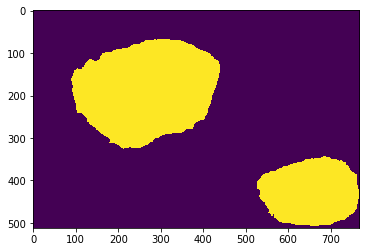

In [18]:
plt.imshow(pred_mask)

In [25]:
(sub_df.EncodedPixels!='').mean()

0.39034613304488913

In [26]:
# sub_df.to_csv('../submission/1115_deeplabv3plus_resnet_512x768_v13_seed2048-50-51.csv.gz', 
#               index=False, compression='gzip')

# sub_df.to_csv('../submission/1116_fpn_resnet34_384x576_v1_seed2100-01-02-03-04.csv.gz', 
#               index=False, compression='gzip')

sub_df.to_csv('../submission/1117_fpn_resnet34_576x768_v1_seed2150-51-52-53-54.csv.gz', 
              index=False, compression='gzip')

# sub_df.to_csv('../submission/1115_unet_resnet34_512x768_v1_seed2060-61-62.csv.gz', 
#               index=False, compression='gzip')

# sub_df.to_csv('../submission/1116_unet_resnet34_384x576_v1_seed2080-81-82-83-84.csv.gz', 
#               index=False, compression='gzip')

# sub_df.to_csv('../submission/1116_pspnet_resnet34_512x768_v1_seed2070-71-72-73-74.csv.gz', 
#               index=False, compression='gzip')

# sub_df.to_csv('../submission/1116_pspnet_resnet34_384x576_v1_seed2090-91-92-93-94.csv.gz', 
#               index=False, compression='gzip')

In [53]:
# ### for ensemble
# sub_df.to_csv('../submission/sigmoid_ensemble.csv.gz', index=False, compression='gzip')

In [105]:
(pd.read_csv('../data/raw/train.csv').fillna('').EncodedPixels!='').mean()

0.5335376848178868

In [ ]:
#this is for remembering best thresholds of those already submitted solutions
sub_df.to_csv('submission/del.csv.gz', index=False, compression='gzip')

In [34]:
sub_kaggler = pd.read_csv('../submission/kaggler0_submission_segmentation_and_classifier.csv').fillna('')
(sub_kaggler.EncodedPixels!='').mean()

0.44503785830178477

## maybe a leak
every image has at least one label, force to predict non-empty-mask

In [4]:
#sub_df = pd.read_csv('../submission/dirty_ensemble.csv.gz').fillna('')
sub = copy.deepcopy(sub_df)

sub['img_id'] = [name.split('.')[0] for name in sub.Image_Label]
sub['has_mask'] = (sub.EncodedPixels!='').astype(np.int)
sub.head(3)

,Image_Label,EncodedPixels,img_id,has_mask
0,10055ff.jpg_Fish,,10055ff,0
1,10055ff.jpg_Flower,,10055ff,0
2,10055ff.jpg_Gravel,1217 45 1268 7 1560 2 1564 63 1899 3 1903 81 2...,10055ff,1


In [5]:
agg = sub.groupby(['img_id'])['has_mask'].agg(['sum'])
agg['sum'].value_counts()# / 3698

2    1816
1    1410
3     404
0      56
4      12
Name: sum, dtype: int64

In [31]:
%%time

ensemble = False#True

relaxed_threshold_EMPTY = 1

#### Generate rle encodings
rles = []
for p in tqdm_notebook(preds_test):#p is logit from model
    found = False
    for ch in range(4):
        pred_mask = predict_mask(p[ch], best_threshold_EMPTY[ch], best_threshold_MASK[ch], use_sigmoid=(not ensemble))#False ensemble
        if pred_mask.sum()>0:#predicted non-empty mask
            pred_mask = cv2.resize(pred_mask.astype('float32'), (525, 350))
            pred_mask = (pred_mask>0.5).astype(np.uint8)
            rles.append(mask2rle(pred_mask))
            found = True
        else:
            rles.append('')
    ##if predict 4-channel-all-empty
    if not found:
        pred_mask_4ch = []
        pred_mask_sum = []
        for ch in range(4):
            pred_mask = predict_mask(p[ch], relaxed_threshold_EMPTY, best_threshold_MASK[ch], use_sigmoid=(not ensemble))#False ensemble
            pred_mask_sum.append(pred_mask.sum())
            pred_mask_4ch.append(pred_mask)
        if np.sum(pred_mask_sum)==0:
            continue
        else:
            ch_idx = np.argmax(pred_mask_sum)#pick the channel with maximum mask area
            pred_mask = pred_mask_4ch[ch_idx]
            ##replace empty mask with new mask
            pred_mask = cv2.resize(pred_mask.astype('float32'), (525, 350))
            pred_mask = (pred_mask>0.5).astype(np.uint8)
            rles[-(4-ch_idx)] = mask2rle(pred_mask)



CPU times: user 13min 26s, sys: 25.1 s, total: 13min 51s
Wall time: 50.4 s


In [32]:
img_id_ch = []
for fname in test_fnames:
    for name in ['Fish', 'Flower', 'Gravel', 'Sugar']:
        img_id_ch.append(fname+'.jpg_%s'%name)

sub_df = pd.DataFrame({'Image_Label': img_id_ch, 'EncodedPixels': rles})
print(len(sub_df.index))

14792


In [33]:
(sub_df.EncodedPixels!='').mean()

0.4398323418063818

In [34]:
sub_df.to_csv('../submission/1109_deeplabv3plus_resnet_512x768_v10_seed2022-4ch-empty-fix.csv.gz', 
              index=False, compression='gzip')